# Table of Contents

1. [Restructuring the JSON Data](#Restructuring-The-JSON-Data)
2. [Preprocessing](#Preprocessing-JSON-to-Tabular)
3. [Troubleshooting](#Troubleshooting.)
6.   [Random Forest Model to Predict Carrier](#Random-Forest-Model-to-Predict-Carrier)
7.    [Random Forest Results](#Random-Forest-Results)
9. [LightGBM](#LightGBM)
14. [Time Series Analysis](#Time-Series-Analysis)
15. [Time Series Results](#Time-Series-Results)




In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = pd.read_csv('Downloads/Result_1.csv')
print(df.head())

       created_at                                      filtered_json  \
0  10/29/24 21:27  {"policy": {"address": {"zip": null, "city": n...   
1  10/29/24 21:03  {"policy": {"address": {"zip": null, "city": n...   
2  10/29/24 19:56  {"policy": {"address": {"zip": null, "city": n...   
3  10/29/24 18:37  {"policy": {"address": {"zip": null, "city": n...   
4  10/29/24 16:44  {"policy": {"address": {"zip": null, "city": n...   

  CreatedDate    Carrier  vrna_policy_type_c vrna_effective_date_c  \
0     11/9/23        NaN  Commercial Package              11/10/23   
1     11/9/23        NaN  Commercial Package              11/10/23   
2     11/9/23        NaN  Commercial Package              11/10/23   
3    10/29/24  Dairyland       Personal Auto              10/29/24   
4    10/29/24   Lemonade          Homeowners              10/30/24   

  vrna_expiration_date_c  vrna_initial_premium_amount_c vrna_status_c  Term  \
0                11/9/24                            NaN       Expir

In [9]:
df.shape

(516, 20)

In [11]:
df.describe

<bound method NDFrame.describe of          created_at                                      filtered_json  \
0    10/29/24 21:27  {"policy": {"address": {"zip": null, "city": n...   
1    10/29/24 21:03  {"policy": {"address": {"zip": null, "city": n...   
2    10/29/24 19:56  {"policy": {"address": {"zip": null, "city": n...   
3    10/29/24 18:37  {"policy": {"address": {"zip": null, "city": n...   
4    10/29/24 16:44  {"policy": {"address": {"zip": null, "city": n...   
..              ...                                                ...   
511     9/3/24 0:48  {"policy": {"address": {"zip": null, "city": n...   
512   8/28/24 20:03  {"policy": {"address": {"zip": null, "city": n...   
513   8/27/24 20:36  {"policy": {"address": {"zip": null, "city": n...   
514    8/2/24 17:54  {"policy": {"address": {"zip": null, "city": n...   
515   7/31/24 10:08  {"policy": {"address": {"zip": null, "city": n...   

    CreatedDate      Carrier  vrna_policy_type_c vrna_effective_date_c  \
0  

In [13]:
df.columns

Index(['created_at', 'filtered_json', 'CreatedDate', 'Carrier',
       'vrna_policy_type_c', 'vrna_effective_date_c', 'vrna_expiration_date_c',
       'vrna_initial_premium_amount_c', 'vrna_status_c', 'Term',
       'Month_Premium', 'Multi_Ind', 'LTV_Rate', 'Mono_LTMonths', 'LTV_Months',
       'Est_LTV', 'ReferralSource', 'State', 'LongCode', 'rn'],
      dtype='object')

In [15]:
# Viewing Entire JSON String


filtered_json_column = df['filtered_json']
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_colwidth', None)  # Show full content of each cell

# Display the entire 'filtered_json' column
print(filtered_json_column)

0                                                                                                                                                                                                                                                             {"policy": {"address": {"zip": null, "city": null, "plus4": null, "state": null, "county": null}, "coverages": null, "coverageTier": null, "eSignDocument": null, "effectiveDate": null, "expirationDate": null, "isValidAddress": null, "acceptUpdatedPrice": null}, "vehicles": [{"id": "1", "make": "honda", "trim": "TOURING", "year": "2020", "model": "pilot", "coverages": "{\"tort\": \"\", \"rental\": \"\", \"towing\": \"\", \"medical\": \"\", \"collision\": \"\", \"pipMedical\": \"\", \"bodilyInjury\": \"\", \"comprehensive\": \"\", \"pipDeductible\": \"\", \"pipIncomeLoss\": \"\", \"propertyDamage\": \"\", \"uninsuredMotorist\": \"\", \"pipAccidentalDeath\": \"\", \"underInsuredMotorist\": \"\", \"customPartsAndEquipment\": \"\", \"persona

## Restructuring The JSON Data

The Policy holder info was imputed into a columns named 'filtered_json' it's done with nested JSON strings, empty inputs and null values. The below will be the extraction, cleaning and converting to a tabular data set. 

**There should be 5 main strings and nested strings within them**

1. **'policy'**: {'address': {'zip': None, 'city': None, 'plus4': None, 'state': None, 'county': None}, 
'coverages': None, 'coverageTier': None, 'eSignDocument': None, 'effectiveDate': None, 'expirationDate': None, 'isValidAddress': None, 'acceptUpdatedPrice': None},

2. **'vehicles'**: [{'id': '1', 'make': 'honda', 'trim': 'TOURING', 'year': '2020', 'model': 'pilot',

**'coverages’**: '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsuredMotorist": "", "pipAccidentalDeath": "", "underInsuredMotorist": "", "customPartsAndEquipment": "", "personalInjuryProtection": "", "uninsuredMotoristPropertyDamage": ""}', 'partialVin': '5FNYF5H60LB000000', 'primaryUse': 'Commute', 'fullCoverage': 'Yes', 'annualMileage': '3650', 'ownershipStatus': 'Own', 'rideShareCoverage': 'false'}], 

3. **'discounts'**: {'paperless': True, 'payInFull': True, 'goodStudent': False, 'ubiEnrollment': True, 'defensiveDriver': True, 'rightTrackProgram': {'enroll': '', 'phoneNumber': ''},
4. **'multiPolicyDiscount'**: {'home': False, 'life': False, 'condo': False, 'renter': False, 'landlord': False, 'property': False, 'umbrella': False, 'motorcycle': False, 'watercraft': False, 'recreationalVehicle': False}, 'hasNonAutoCarrierPolicy': ''},
5. **'operators'**: [{'id': '1', 'age': 44, 'sr22': {'filingDate': '', 'isRequired': 'No', 'filingEndDate': '', 'filingCaseNumber': ''}, 'gender': 'Male',
 'carrier': 'Allstate', 
'education': "Bachelor's Degree", 

'incidents': '{"hasDui": "No", "accidents": [], "violations": [], "ticketNumber": "0", "hasAtFaultAccident": "0", "isDriversLicenseSuspended": "No"}', 

'isPrimary': 'true', 
'occupation': 'Manager/Supervisor', 
'creditScore': 'Excellent (750+)', 'licenseState': '', 'relationship': 'Self', 'timeEmployed': '', 'maritalStatus': 'No', 'licenseObtainedAge': '', 'homeOwnershipStatus': 'Own', 'isExperiencedDriver': '', 'militaryAffiliation': 'No', 'hasCancelledInsurance': '', 'yearsWithCurrentCarrier': '3-4 years', 'yearsContinuouslyInsured': ''}]}







In [18]:
df.head(1)

created_at  \
0  10/29/24 21:27   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          filtered_json  \
0  {"policy": {"address": {"zip": null, "city": null, "plus4": null, "state": null, "county": null}, "coverages": null, "coverageTier": null, "eSignDocument": null, "effectiveDate": null, "expirationDate": null, "isValidAddress": null, "acceptUpdatedPrice": null}, "vehicles": [{"id": "1", "make": "honda", "trim": "TOURING", "year": "2020", "model": "pilot", "coverages": "{\"tort\": \"\", \"rental\": \"\", \"towing\": \"\", \"medical\": \"\", \"collision\": \"\", \"pipMedical\": \"\", \"bodilyInjury\": \"\", \"comprehensive\": \"\", \"pipDeductible\": \"\", \"pipIncomeLoss\": \"\", \"propertyDamage\": \"\", \"uninsuredMotorist\": \"\", \"pipAccidentalDeath\": \"\", \"underInsuredMotorist\": \"\", \"customPartsAndEquipment\": \"\", \"personalInjuryProtection\": \"\", \"uninsuredMotoristPropertyDamage\": \"\"}", "partialVin": "5FNYF5H60LB000000", "primaryUse": "Commute", "fullCoverage": "Yes", "annualMileage": "3650", "ownershipStatus": "Own", "rideShareCoverage": "false"}], "discounts": {"paperless": true, "payInFull": true, "goodStudent": false, "ubiEnrollment": true, "defensiveDriver": true, "rightTrackProgram": {"enroll": "", "phoneNumber": ""}, "multiPolicyDiscount": {"home": false, "life": false, "condo": false, "renter": false, "landlord": false, "property": false, "umbrella": false, "motorcycle": false, "watercraft": false, "recreationalVehicle": false}, "hasNonAutoCarrierPolicy": ""}, "operators": [{"id": "1", "age": 44, "sr22": {"filingDate": "", "isRequired": "No", "filingEndDate": "", "filingCaseNumber": ""}, "gender": "Male", "carrier": "Allstate", "education": "Bachelor's Degree", "incidents": "{\"hasDui\": \"No\", \"accidents\": [], \"violations\": [], \"ticketNumber\": \"0\", \"hasAtFaultAccident\": \"0\", \"isDriversLicenseSuspended\

In [20]:
import json

filtered_json_dict = df['filtered_json'].apply(lambda x: json.loads(x) if isinstance(x, str) else {})

flattened_json_data = pd.json_normalize(filtered_json_dict, sep='_')

df = pd.concat([df.drop(columns=['filtered_json']).reset_index(drop=True), flattened_json_data.reset_index(drop=True)], axis=1)


In [22]:
df.head()

created_at CreatedDate    Carrier  vrna_policy_type_c  \
0  10/29/24 21:27     11/9/23        NaN  Commercial Package   
1  10/29/24 21:03     11/9/23        NaN  Commercial Package   
2  10/29/24 19:56     11/9/23        NaN  Commercial Package   
3  10/29/24 18:37    10/29/24  Dairyland       Personal Auto   
4  10/29/24 16:44    10/29/24   Lemonade          Homeowners   

  vrna_effective_date_c vrna_expiration_date_c  vrna_initial_premium_amount_c  \
0              11/10/23                11/9/24                            NaN   
1              11/10/23                11/9/24                            NaN   
2              11/10/23                11/9/24                            NaN   
3              10/29/24                4/29/25                         546.28   
4              10/30/24               10/30/25                         150.00   

  vrna_status_c  Term  Month_Premium  ...  \
0       Expired  11.0            NaN  ...   
1       Expired  11.0            NaN  ...   
2       Expired  11.0            NaN  ...   
3           New   6.0          91.05  ...   
4           New  12.0          12.50  ...   

   discounts_multiPolicyDiscount_condo  discounts_multiPolicyDiscount_renter  \
0                                False                                 False   
1                                False                                 False   
2                                False                                 False   
3                                False                                 False   
4                                False                                 False   

  discounts_multiPolicyDiscount_landlord  \
0                                  False   
1                                  False   
2                                  False   
3                                  False   
4                                  False   

  discounts_multiPolicyDiscount_property  \
0                                  False   
1                                  False   
2                                  False   
3                                  False   
4                                   True   

   discounts_multiPolicyDiscount_umbrella  \
0                                   False   
1                                   False   
2                                   False   
3                                   False   
4                                   False   

  discounts_multiPolicyDiscount_motorcycle  \
0                                    False   
1                                    False   
2                                    False   
3                                    False   
4                                    False   

  discounts_multiPolicyDiscount_watercraft  \
0                                    False   
1                                    False   
2                                    False   
3                                    False   
4                                    False   

  discounts_multiPolicyDiscount_recreationalVehicle  \
0                                             False   
1                                             False   
2                                             False   
3                                             False   
4                                             False   

   discounts_hasNonAutoCarrierPolicy discounts  
0                                          NaN  
1                                          NaN  
2                                          NaN  
3                                          NaN  
4                                          NaN  

[5 rows x 52 columns]

In [24]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 1000)  

df.sample(1)

created_at CreatedDate           Carrier vrna_policy_type_c vrna_effective_date_c vrna_expiration_date_c  vrna_initial_premium_amount_c vrna_status_c  Term  Month_Premium  Multi_Ind  LTV_Rate Mono_LTMonths LTV_Months  Est_LTV        ReferralSource State                                   LongCode  rn                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               vehicles  \
33  10/22/24 13:57    10/22/24  National General      Personal Auto              10/22/24                4/22/25                          880.0           New   6.0         146.67        NaN      0.09            24         24   316.81  BR Auto Results Page    OH  National GeneralPersonal Auto202542268900   1  [{'id': '1', 'make': 'ford', 'trim': 'LIMITED', 'year': '2012', 'model': 'escape', 'coverages': '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsuredMotorist": "", "pipAccidentalDeath": "", "underInsuredMotorist": "", "customPartsAndEquipment": "", "personalInjuryProtection": "", "uninsuredMotoristPropertyDamage": ""}', 'partialVin': '1FMCU0E70CK000000', 'primaryUse': 'Pleasure', 'fullCoverage': 'Yes', 'annualMileage': '4000', 'ownershipStatus': 'Finance', 'rideShareCoverage': 'false'}]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          operators policy_address_zip policy_address_city policy_address_plus4 policy_address_state policy_address_county policy_coverages policy_coverageTier policy_eSignDocument policy_effectiveDate policy_expirationDate policy_isValidAddress  \
33  [{'id': '1', 'age': 40, 'sr22': {'filingDate': '', 'isRequired': 'No', 'filingEndDate': '', 'filingCaseNumber': ''}, 'gender': 'Female', 'carrier': 'The General', 'education': 'High School Diploma', 'incidents': '{"hasDui": "No", "accidents": [], "violations": [], "ticketNumber": "0", "hasAtFaultAccident": "0", "isDriversLicenseSuspended": "No"}', 'isPrimary': 'true', 'occupation': 'Manager/Supervisor', 'creditScore': 'Needs work (<640)', 'licenseState': '', 'relationship': 'Self', 'timeEmployed': '', 'maritalStatus': 'No', 'licenseObtainedAge': '', 'homeOwnershipStatus': 'Rent', 'isExperiencedDriver': '', 'militaryAffiliation': 'No', 'hasCancelledInsurance': '', 'yearsWithCurrentCarrier': 'Less than a year', 'yearsContinuouslyInsured': ''}]               None                None                 None                 None                  None             None                None                 None                 None                  None                  None   

   policy_acceptUpdatedPrice discounts_paperless discounts_payInFull discounts_goodStudent discounts_ubiEnrollment dis

### Preprocessing JSON to Tabular

Needing to convert JSON to tabular in
- vheciles
- operators
- discounts

Then concatenate the new df files in with the original df. 

In [27]:
flattened_json_data.head()

vehicles  \
0  [{'id': '1', 'make': 'honda', 'trim': 'TOURING', 'year': '2020', 'model': 'pilot', 'coverages': '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsuredMotorist": "", "pipAccidentalDeath": "", "underInsuredMotorist": "", "customPartsAndEquipment": "", "personalInjuryProtection": "", "uninsuredMotoristPropertyDamage": ""}', 'partialVin': '5FNYF5H60LB000000', 'primaryUse': 'Commute', 'fullCoverage': 'Yes', 'annualMileage': '3650', 'ownershipStatus': 'Own', 'rideShareCoverage': 'false'}]   
1   [{'id': '1', 'make': 'ford', 'trim': 'XLT', 'year': '2020', 'model': 'explorer', 'coverages': '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsuredMotorist": "", "pipAccidentalDeath": "", "underInsuredMotorist": "", "customPartsAndEquipment": "", "personalInjuryProtection": "", "uninsuredMotoristPropertyDamage": ""}', 'partialVin': '1FM5K7DH0LG000000', 'primaryUse': 'Commute', 'fullCoverage': 'Yes', 'annualMileage': '18250', 'ownershipStatus': 'Own', 'rideShareCoverage': 'false'}]   
2  [{'id': '1', 'make': 'honda', 'trim': 'TOURING', 'year': '2020', 'model': 'pilot', 'coverages': '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsuredMotorist": "", "pipAccidentalDeath": "", "underInsuredMotorist": "", "customPartsAndEquipment": "", "personalInjuryProtection": "", "uninsuredMotoristPropertyDamage": ""}', 'partialVin': '5FNYF5H60LB000000', 'primaryUse': 'Commute', 'fullCoverage': 'Yes', 'annualMileage': '7500', 'ownershipStatus': 'Own', 'rideShareCoverage': 'false'}]   
3         [{'id': '1', 'make': 'dodge', 'trim': 'SLT', 'year': '2002', 'model': 'dakota', 'coverages': '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsuredMotorist": "", "pipAccidentalDeath": "", "underInsuredMotorist": "", "customPartsAndEquipment": "", "personalInjuryProtection": "", "uninsuredMotoristPropertyDamage": ""}', 'partialVin': '1B7FL46N02S000000', 'primaryUse': 'Other', 'fullCoverage': 'No', 'annualMileage': '730', 'ownershipStatus': 'Own', 'rideShareCoverage': 'false'}]   
4   [{'id': '1', 'make': 'hyundai', 'trim': 'SE', 'year': '2016', 'model': 'elantra', 'coverages': '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsuredMotorist": "", "pipAccidentalDeath": "", "underInsuredMotorist": "", "customPartsAndEquipment": "", "personalInjuryProtection": "", "uninsuredMotoristPropertyDamage": ""}', 'partialVin': '5NPDH4AD0GH000000', 'primaryUse': 'Commute', 'fullCoverage': 'Yes', 'annualMileage': '6205', 'ownershipStatus': 'Own', 'rideShareCoverage': 'false'}]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 operators polic

In [29]:
import json

# Check if a sample row from a column contains JSON
try:
    sample_data = json.loads(df['vehicles'].iloc[0])
    print("Column 'vehicles' contains JSON data.")
except (json.JSONDecodeError, TypeError):
    print("Column 'vehicles' does not contain JSON data.")

Column 'vehicles' does not contain JSON data.


In [31]:
df['vehicles']

0                            [{'id': '1', 'make': 'honda', 'trim': 'TOURING', 'year': '2020', 'model': 'pilot', 'coverages': '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsuredMotorist": "", "pipAccidentalDeath": "", "underInsuredMotorist": "", "customPartsAndEquipment": "", "personalInjuryProtection": "", "uninsuredMotoristPropertyDamage": ""}', 'partialVin': '5FNYF5H60LB000000', 'primaryUse': 'Commute', 'fullCoverage': 'Yes', 'annualMileage': '3650', 'ownershipStatus': 'Own', 'rideShareCoverage': 'false'}]
1                             [{'id': '1', 'make': 'ford', 'trim': 'XLT', 'year': '2020', 'model': 'explorer', 'coverages': '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsure

## Troubleshooting. 

'vehciles' and 'operators' data didn't get included in the df_cleaned below. I believe it was b/c I tried to do them all int he same code block. I'll try again sequentially and integrate them into df_cleaned individually. 

### Cont. 

I tried to flatten individually and found that the flatten is failing silently. I tried flattening the 'vehicles' tab first and it removed the JSON strings and the 'vehicles' column but didn't add the new columns into the new df. 

### Cont. 

After checking the output of json.loads it looks like it wasn't parsing the data correctly. Then I ran  .dtype and it was 'object' but when I ran .iloc to inspect the column further it showed that it wasn't JSON data I was looking at but a list of dictionaries rather than a JSON string (eyeroll). 

In [34]:
# extracting 'operators' dictionary

operators_dict = df['operators'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
print(operators_dict.head())  # Check the resulting dictionary-like structures

0            {'id': '1', 'age': 44, 'sr22': {'filingDate': '', 'isRequired': 'No', 'filingEndDate': '', 'filingCaseNumber': ''}, 'gender': 'Male', 'carrier': 'Allstate', 'education': 'Bachelor's Degree', 'incidents': '{"hasDui": "No", "accidents": [], "violations": [], "ticketNumber": "0", "hasAtFaultAccident": "0", "isDriversLicenseSuspended": "No"}', 'isPrimary': 'true', 'occupation': 'Manager/Supervisor', 'creditScore': 'Excellent (750+)', 'licenseState': '', 'relationship': 'Self', 'timeEmployed': '', 'maritalStatus': 'No', 'licenseObtainedAge': '', 'homeOwnershipStatus': 'Own', 'isExperiencedDriver': '', 'militaryAffiliation': 'No', 'hasCancelledInsurance': '', 'yearsWithCurrentCarrier': '3-4 years', 'yearsContinuouslyInsured': ''}
1            {'id': '1', 'age': 44, 'sr22': {'filingDate': '', 'isRequired': 'No', 'filingEndDate': '', 'filingCaseNumber': ''}, 'gender': 'Male', 'carrier': 'Allstate', 'education': 'Bachelor's Degree', 'incidents': '{"hasDui": "No", "accidents": [], "

In [36]:
#Now flattening the new operators dtci

operators_dict = pd.json_normalize(operators_dict)
print(operators_dict.head())  

  id   age  gender         carrier          education                                                                                                                               incidents isPrimary          occupation        creditScore licenseState relationship timeEmployed maritalStatus licenseObtainedAge homeOwnershipStatus isExperiencedDriver militaryAffiliation hasCancelledInsurance yearsWithCurrentCarrier yearsContinuouslyInsured sr22.filingDate sr22.isRequired sr22.filingEndDate sr22.filingCaseNumber  sr22
0  1  44.0    Male        Allstate  Bachelor's Degree  {"hasDui": "No", "accidents": [], "violations": [], "ticketNumber": "0", "hasAtFaultAccident": "0", "isDriversLicenseSuspended": "No"}      true  Manager/Supervisor   Excellent (750+)                      Self                         No                                    Own                                      No                                     3-4 years                                                       No      

In [38]:
# now I'll add the flattened operators data back into the original df

df_cleaned = pd.concat([df.drop(columns=['operators']).reset_index(drop=True), operators_dict.reset_index(drop=True)], axis=1)

df_cleaned.head(1)

created_at CreatedDate Carrier  vrna_policy_type_c vrna_effective_date_c vrna_expiration_date_c  vrna_initial_premium_amount_c vrna_status_c  Term  Month_Premium  Multi_Ind  LTV_Rate Mono_LTMonths LTV_Months  Est_LTV ReferralSource State LongCode  rn                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          vehicles policy_address_zip policy_address_city policy_address_plus4 policy_address_state  \
0  10/29/24 21:27     11/9/23     NaN  Commercial Package              11/10/23                11/9/24                            NaN       Expired  11.0            NaN        NaN       NaN           NaN        NaN      NaN        Website    MA      NaN   1  [{'id': '1', 'make': 'honda', 'trim': 'TOURING', 'year': '2020', 'model': 'pilot', 'coverages': '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsuredMotorist": "", "pipAccidentalDeath": "", "underInsuredMotorist": "", "customPartsAndEquipment": "", "personalInjuryProtection": "", "uninsuredMotoristPropertyDamage": ""}', 'partialVin': '5FNYF5H60LB000000', 'primaryUse': 'Commute', 'fullCoverage': 'Yes', 'annualMileage': '3650', 'ownershipStatus': 'Own', 'rideShareCoverage': 'false'}]               None                None                 None                 None   

  policy_address_county policy_coverages policy_coverageTier policy_eSignDocument policy_effectiveDate policy_expirationDate policy_isValidAddress policy_acceptUpdatedPrice discounts_paperless discounts_payInFull discounts_goodStudent discounts_ubiEnrollment discounts_defensiveDriver discounts_rightTrackProgram_enroll discounts_rightTrackProgram_phoneNumber discounts_multiPolicyDiscount_home discounts_multiPolicyDiscount_life discounts_multiPolicyDiscount_condo discounts_multiPolicyDiscount_renter discounts_multiPolicyDiscount_landlord discounts_multiPolicyDiscount_property discounts_multiPolicyDiscount_umbrella discounts_multiPolicyDiscount_motorcycle discounts_multiPolicyDiscount_watercraft discounts_multiPolicyDiscount_recreationalVehicle discounts_hasNonAutoCarrierPolicy  discounts id   age gender   carrier          education                                                                                                                               incidents isPrimary  \
0                  None             None                None                 None                 None                  None                  None                      None                True                True                 False                    True                      True                                                                                                         False                              False                               False                                False                                  False                                  False                                  False                                    False                                    False                                             False                                          NaN  1  44.0   Male  Allstate  Bachelor's Degree  {"hasDui": "No", "accidents": [], "violations": [], "ticketNumber": "0", "hasAtFaultAccident": "0", "isDriversLicenseSuspended": "No"}      true   

           occupation       creditScore licenseState re

In [40]:
# now to extract indicents


# Flatten the `incidents` column
incidents_dict = df_cleaned['incidents'].apply(lambda x: json.loads(x) if isinstance(x, str) else None)
incidents_data = pd.json_normalize(incidents_dict)

# Drop the original `incidents` column from `df_cleaned`
df_cleaned = df_cleaned.drop(columns=['incidents'])

# Concatenate `incidents_data` with the main DataFrame
df_cleaned = pd.concat([df_cleaned.reset_index(drop=True), incidents_data.reset_index(drop=True)], axis=1)

print(df_cleaned.head(1))



       created_at CreatedDate Carrier  vrna_policy_type_c vrna_effective_date_c vrna_expiration_date_c  vrna_initial_premium_amount_c vrna_status_c  Term  Month_Premium  Multi_Ind  LTV_Rate Mono_LTMonths LTV_Months  Est_LTV ReferralSource State LongCode  rn                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          vehicles policy_address_zip policy_address_city policy_address_plus4 policy_address_state  \
0  10/29/24 21:2

In [42]:
df_cleaned.head(1)

created_at CreatedDate Carrier  vrna_policy_type_c vrna_effective_date_c vrna_expiration_date_c  vrna_initial_premium_amount_c vrna_status_c  Term  Month_Premium  Multi_Ind  LTV_Rate Mono_LTMonths LTV_Months  Est_LTV ReferralSource State LongCode  rn                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          vehicles policy_address_zip policy_address_city policy_address_plus4 policy_address_state  \
0  10/29/24 21:27     11/9/23     NaN  Commercial Package              11/10/23                11/9/24                            NaN       Expired  11.0            NaN        NaN       NaN           NaN        NaN      NaN        Website    MA      NaN   1  [{'id': '1', 'make': 'honda', 'trim': 'TOURING', 'year': '2020', 'model': 'pilot', 'coverages': '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsuredMotorist": "", "pipAccidentalDeath": "", "underInsuredMotorist": "", "customPartsAndEquipment": "", "personalInjuryProtection": "", "uninsuredMotoristPropertyDamage": ""}', 'partialVin': '5FNYF5H60LB000000', 'primaryUse': 'Commute', 'fullCoverage': 'Yes', 'annualMileage': '3650', 'ownershipStatus': 'Own', 'rideShareCoverage': 'false'}]               None                None                 None                 None   

  policy_address_county policy_coverages policy_coverageTier policy_eSignDocument policy_effectiveDate policy_expirationDate policy_isValidAddress policy_acceptUpdatedPrice discounts_paperless discounts_payInFull discounts_goodStudent discounts_ubiEnrollment discounts_defensiveDriver discounts_rightTrackProgram_enroll discounts_rightTrackProgram_phoneNumber discounts_multiPolicyDiscount_home discounts_multiPolicyDiscount_life discounts_multiPolicyDiscount_condo discounts_multiPolicyDiscount_renter discounts_multiPolicyDiscount_landlord discounts_multiPolicyDiscount_property discounts_multiPolicyDiscount_umbrella discounts_multiPolicyDiscount_motorcycle discounts_multiPolicyDiscount_watercraft discounts_multiPolicyDiscount_recreationalVehicle discounts_hasNonAutoCarrierPolicy  discounts id   age gender   carrier          education isPrimary          occupation       creditScore licenseState relationship timeEmployed maritalStatus licenseObtainedAge homeOwnershipStatus  \
0                  None             None                None                 None                 None                  None                  None                      None                True                True                 False                    True                      True                                                                                                         False                              False                               False                                False                                  False                                  False                                  False                                    False                                    False                                             False                                          NaN  1  44.0   Male  Allstate  Bachelor's Degree      true  Manager/Supervisor  Excellent (750+)                      Self                         No                                    Own   

  isExperiencedDriver militaryAffiliation hasCancelledInsurance yea

In [44]:

vehicles_dict = df['vehicles'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else {})

print(vehicles_dict.head())  


0    {'id': '1', 'make': 'honda', 'trim': 'TOURING', 'year': '2020', 'model': 'pilot', 'coverages': '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsuredMotorist": "", "pipAccidentalDeath": "", "underInsuredMotorist": "", "customPartsAndEquipment": "", "personalInjuryProtection": "", "uninsuredMotoristPropertyDamage": ""}', 'partialVin': '5FNYF5H60LB000000', 'primaryUse': 'Commute', 'fullCoverage': 'Yes', 'annualMileage': '3650', 'ownershipStatus': 'Own', 'rideShareCoverage': 'false'}
1     {'id': '1', 'make': 'ford', 'trim': 'XLT', 'year': '2020', 'model': 'explorer', 'coverages': '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsuredMotorist": "", "pipAccidentalDeath": "", "underIns

In [46]:
vehicles_data = pd.json_normalize(vehicles_dict)

In [48]:

df_cleaned = df_cleaned.drop(columns=['vehicles'])

df_cleaned = pd.concat([df_cleaned.reset_index(drop=True), vehicles_data.reset_index(drop=True)], axis=1)

print(df_cleaned.head())

       created_at CreatedDate    Carrier  vrna_policy_type_c vrna_effective_date_c vrna_expiration_date_c  vrna_initial_premium_amount_c vrna_status_c  Term  Month_Premium  Multi_Ind  LTV_Rate Mono_LTMonths LTV_Months  Est_LTV        ReferralSource State                           LongCode  rn policy_address_zip policy_address_city policy_address_plus4 policy_address_state policy_address_county policy_coverages policy_coverageTier policy_eSignDocument policy_effectiveDate policy_expirationDate policy_isValidAddress policy_acceptUpdatedPrice discounts_paperless discounts_payInFull discounts_goodStudent discounts_ubiEnrollment discounts_defensiveDriver discounts_rightTrackProgram_enroll discounts_rightTrackProgram_phoneNumber discounts_multiPolicyDiscount_home discounts_multiPolicyDiscount_life discounts_multiPolicyDiscount_condo discounts_multiPolicyDiscount_renter discounts_multiPolicyDiscount_landlord discounts_multiPolicyDiscount_property discounts_multiPolicyDiscount_umbrella  \
0  1

In [50]:
df_cleaned.sample(1)

created_at CreatedDate      Carrier vrna_policy_type_c vrna_effective_date_c vrna_expiration_date_c  vrna_initial_premium_amount_c vrna_status_c  Term  Month_Premium  Multi_Ind  LTV_Rate Mono_LTMonths LTV_Months  Est_LTV        ReferralSource State                           LongCode  rn policy_address_zip policy_address_city policy_address_plus4 policy_address_state policy_address_county policy_coverages policy_coverageTier policy_eSignDocument policy_effectiveDate policy_expirationDate policy_isValidAddress policy_acceptUpdatedPrice discounts_paperless discounts_payInFull discounts_goodStudent discounts_ubiEnrollment discounts_defensiveDriver discounts_rightTrackProgram_enroll discounts_rightTrackProgram_phoneNumber discounts_multiPolicyDiscount_home discounts_multiPolicyDiscount_life discounts_multiPolicyDiscount_condo discounts_multiPolicyDiscount_renter discounts_multiPolicyDiscount_landlord discounts_multiPolicyDiscount_property discounts_multiPolicyDiscount_umbrella  \
388  8/12/24 13:20     4/10/24  Progressive      Personal Auto                6/1/24                    NaN                            NaN           New   NaN            NaN        1.0      0.09            36         60      NaN  BR Auto Results Page   NaN  ProgressivePersonal Auto971111111   1               None                None                 None                 None                  None             None                None                 None                 None                  None                  None                      None                True                True                 False                   False                     False                                                                                                         False                              False                               False                                False                                  False                                  False                                  False   

    discounts_multiPolicyDiscount_motorcycle discounts_multiPolicyDiscount_watercraft discounts_multiPolicyDiscount_recreationalVehicle discounts_hasNonAutoCarrierPolicy  discounts id   age  gender   carrier          education isPrimary          occupation       creditScore licenseState relationship timeEmployed maritalStatus licenseObtainedAge homeOwnershipStatus isExperiencedDriver militaryAffiliation hasCancelledInsurance yearsWithCurrentCarrier yearsContinuouslyInsured sr22.filingDate sr22.isRequired sr22.filingEndDate sr22.filingCaseNumber  sr22 hasDui accidents violations ticketNumber hasAtFaultAccident isDriversLicenseSuspended id       make trim  year   model  \
388                                    False                                    False                                             False                                          NaN  1  32.0  Female  Allstate  Bachelor's Degree      true  Manager/Supervisor  Excellent (750+)                      Self                         No                                    Own                                      No                                     3-4 years                                                       No                                            NaN     No        []         []            0                  0                        No  1  chevrolet   SS  2019  camaro   

                                                                                                                                                                                                                                                                                                                                                                                    coverages         partialVin primaryUse fullCoverage annualMileage ownershipStatus rideShareCoverage  
388  {"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": ""

In [52]:
coverages_dict = df_cleaned['coverages'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else {})

coverages_data = pd.json_normalize(coverages_dict)

df_cleaned = df_cleaned.drop(columns=['coverages'])

df_cleaned = pd.concat([df_cleaned.reset_index(drop=True), coverages_data.reset_index(drop=True)], axis=1)

df_cleaned.head()


created_at CreatedDate    Carrier  vrna_policy_type_c vrna_effective_date_c vrna_expiration_date_c  vrna_initial_premium_amount_c vrna_status_c  Term  Month_Premium  Multi_Ind  LTV_Rate Mono_LTMonths LTV_Months  Est_LTV        ReferralSource State                           LongCode  rn policy_address_zip policy_address_city policy_address_plus4 policy_address_state policy_address_county policy_coverages policy_coverageTier policy_eSignDocument policy_effectiveDate policy_expirationDate policy_isValidAddress policy_acceptUpdatedPrice discounts_paperless discounts_payInFull discounts_goodStudent discounts_ubiEnrollment discounts_defensiveDriver discounts_rightTrackProgram_enroll discounts_rightTrackProgram_phoneNumber discounts_multiPolicyDiscount_home discounts_multiPolicyDiscount_life discounts_multiPolicyDiscount_condo discounts_multiPolicyDiscount_renter discounts_multiPolicyDiscount_landlord discounts_multiPolicyDiscount_property discounts_multiPolicyDiscount_umbrella  \
0  10/29/24 21:27     11/9/23        NaN  Commercial Package              11/10/23                11/9/24                            NaN       Expired  11.0            NaN        NaN       NaN           NaN        NaN      NaN               Website    MA                                NaN   1               None                None                 None                 None                  None             None                None                 None                 None                  None                  None                      None                True                True                 False                    True                      True                                                                                                         False                              False                               False                                False                                  False                                  False                                  False   
1  10/29/24 21:03     11/9/23        NaN  Commercial Package              11/10/23                11/9/24                            NaN       Expired  11.0            NaN        NaN       NaN           NaN        NaN      NaN               Website    MA                                NaN   1               None                None                 None                 None                  None             None                None                 None                 None                  None                  None                      None                True                True                 False                    True                      True                                                                                                         False                              False                               False                                False                                  False                                  False                                  False   
2  10/29/24 19:56     11/9/23        NaN  Commercial Package              11/10/23                11/9/24                            NaN       Expired  11.0            NaN        NaN       NaN           NaN        NaN      NaN               Website    MA                                NaN   1               None                None                 None                 None                  None             None                None                 None                 None                  None                  None                      None                True                True                 False                    True                      True                                                                                                         False                              False                               False                                False                                  False                                  False                                  False   
3  10/29/24 18:37    10

In [54]:
# Data is showing up misaligned

print(f"Original DataFrame Rows: {len(df)}")
print(f"Vehicles Data Rows: {len(vehicles_data)}")
print(f"Operators Data Rows: {len(operators_data)}")
print(f"Discounts Data Rows: {len(discounts_data)}")


Original DataFrame Rows: 516
Vehicles Data Rows: 516


NameError: name 'operators_data' is not defined

In [56]:
df_cleaned.head()

# actually it looks like they were always aligned. I just forgot to include the parentheses. 

created_at CreatedDate    Carrier  vrna_policy_type_c vrna_effective_date_c vrna_expiration_date_c  vrna_initial_premium_amount_c vrna_status_c  Term  Month_Premium  Multi_Ind  LTV_Rate Mono_LTMonths LTV_Months  Est_LTV        ReferralSource State                           LongCode  rn policy_address_zip policy_address_city policy_address_plus4 policy_address_state policy_address_county policy_coverages policy_coverageTier policy_eSignDocument policy_effectiveDate policy_expirationDate policy_isValidAddress policy_acceptUpdatedPrice discounts_paperless discounts_payInFull discounts_goodStudent discounts_ubiEnrollment discounts_defensiveDriver discounts_rightTrackProgram_enroll discounts_rightTrackProgram_phoneNumber discounts_multiPolicyDiscount_home discounts_multiPolicyDiscount_life discounts_multiPolicyDiscount_condo discounts_multiPolicyDiscount_renter discounts_multiPolicyDiscount_landlord discounts_multiPolicyDiscount_property discounts_multiPolicyDiscount_umbrella  \
0  10/29/24 21:27     11/9/23        NaN  Commercial Package              11/10/23                11/9/24                            NaN       Expired  11.0            NaN        NaN       NaN           NaN        NaN      NaN               Website    MA                                NaN   1               None                None                 None                 None                  None             None                None                 None                 None                  None                  None                      None                True                True                 False                    True                      True                                                                                                         False                              False                               False                                False                                  False                                  False                                  False   
1  10/29/24 21:03     11/9/23        NaN  Commercial Package              11/10/23                11/9/24                            NaN       Expired  11.0            NaN        NaN       NaN           NaN        NaN      NaN               Website    MA                                NaN   1               None                None                 None                 None                  None             None                None                 None                 None                  None                  None                      None                True                True                 False                    True                      True                                                                                                         False                              False                               False                                False                                  False                                  False                                  False   
2  10/29/24 19:56     11/9/23        NaN  Commercial Package              11/10/23                11/9/24                            NaN       Expired  11.0            NaN        NaN       NaN           NaN        NaN      NaN               Website    MA                                NaN   1               None                None                 None                 None                  None             None                None                 None                 None                  None                  None                      None                True                True                 False                    True                      True                                                                                                         False                              False                               False                                False                                  False                                  False                                  False   
3  10/29/24 18:37    10

In [58]:
df_cleaned

created_at CreatedDate            Carrier  vrna_policy_type_c vrna_effective_date_c vrna_expiration_date_c  vrna_initial_premium_amount_c vrna_status_c  Term  Month_Premium  Multi_Ind  LTV_Rate Mono_LTMonths LTV_Months  Est_LTV         ReferralSource State                                   LongCode  rn policy_address_zip policy_address_city policy_address_plus4 policy_address_state policy_address_county policy_coverages policy_coverageTier policy_eSignDocument policy_effectiveDate policy_expirationDate policy_isValidAddress policy_acceptUpdatedPrice discounts_paperless discounts_payInFull discounts_goodStudent discounts_ubiEnrollment discounts_defensiveDriver discounts_rightTrackProgram_enroll discounts_rightTrackProgram_phoneNumber discounts_multiPolicyDiscount_home discounts_multiPolicyDiscount_life discounts_multiPolicyDiscount_condo discounts_multiPolicyDiscount_renter discounts_multiPolicyDiscount_landlord discounts_multiPolicyDiscount_property  \
0    10/29/24 21:27     11/9/23                NaN  Commercial Package              11/10/23                11/9/24                            NaN       Expired  11.0            NaN        NaN       NaN           NaN        NaN      NaN                Website    MA                                        NaN   1               None                None                 None                 None                  None             None                None                 None                 None                  None                  None                      None                True                True                 False                    True                      True                                                                                                         False                              False                               False                                False                                  False                                  False   
1    10/29/24 21:03     11/9/23                NaN  Commercial Package              11/10/23                11/9/24                            NaN       Expired  11.0            NaN        NaN       NaN           NaN        NaN      NaN                Website    MA                                        NaN   1               None                None                 None                 None                  None             None                None                 None                 None                  None                  None                      None                True                True                 False                    True                      True                                                                                                         False                              False                               False                                False                                  False                                  False   
2    10/29/24 19:56     11/9/23                NaN  Commercial Package              11/10/23                11/9/24                            NaN       Expired  11.0            NaN        NaN       NaN           NaN        NaN      NaN                Website    MA                                        NaN   1               None                None                 None                 None                  None             None                None                 None                 None                  None                  None                      None                True                True                 False                    True                      True                                                                                                         False                              False                               False                                False                                  False                                  False   
3    10/29/24 18:37    10/29/24          Dairyland       Personal Auto              10/29/24             

### Checkpoint Preprocessing: JSON removed and Updated Df

Next:
- check for null values
- remove unnecessary columns

In [61]:
print(df_cleaned.isnull().sum())

created_at                                             0
CreatedDate                                            0
Carrier                                               39
vrna_policy_type_c                                     0
vrna_effective_date_c                                  0
vrna_expiration_date_c                               194
vrna_initial_premium_amount_c                        235
vrna_status_c                                          0
Term                                                 194
Month_Premium                                        237
Multi_Ind                                            298
LTV_Rate                                              39
Mono_LTMonths                                         39
LTV_Months                                            40
Est_LTV                                              237
ReferralSource                                         7
State                                                230
LongCode                       

In [63]:
df_cleaned.shape

(516, 91)

In [65]:
df_cleaned["LongCode"]
# Bailey said this was likley just a identifier from the coverage team. Removing

0                                            NaN
1                                            NaN
2                                            NaN
3              DairylandPersonal Auto11409827387
4                  LemonadeHomeownersLP25C86DE06
5        National GeneralPersonal Auto2025533588
6                                            NaN
7      National GeneralPersonal Auto202551741200
8              ProgressivePersonal Auto971111111
9          Assurance AmericaHomeowners0011038302
10             DairylandPersonal Auto11409827387
11         Bristol WestPersonal AutoG01537202600
12         Bristol WestPersonal AutoG01537202600
13         Bristol WestPersonal AutoG01537202600
14     National GeneralPersonal Auto202548331100
15             ProgressivePersonal Auto971111111
16         Assurance AmericaHomeowners0011038302
17             ProgressivePersonal Auto971111111
18         Assurance AmericaHomeowners0011038302
19       National GeneralPersonal Auto2025533588
20     National Gene

In [67]:
df_cleaned["Multi_Ind"]

# Can remove

0      NaN
1      NaN
2      NaN
3      NaN
4      1.0
5      NaN
6      NaN
7      NaN
8      1.0
9      1.0
10     NaN
11     NaN
12     NaN
13     NaN
14     NaN
15     1.0
16     1.0
17     1.0
18     1.0
19     NaN
20     NaN
21     NaN
22     NaN
23     NaN
24     NaN
25     1.0
26     1.0
27     1.0
28     1.0
29     1.0
30     1.0
31     1.0
32     NaN
33     NaN
34     NaN
35     NaN
36     NaN
37     1.0
38     NaN
39     NaN
40     NaN
41     1.0
42     1.0
43     NaN
44     NaN
45     NaN
46     1.0
47     1.0
48     NaN
49     NaN
50     NaN
51     NaN
52     NaN
53     NaN
54     1.0
55     1.0
56     NaN
57     NaN
58     1.0
59     1.0
60     NaN
61     NaN
62     NaN
63     NaN
64     NaN
65     NaN
66     NaN
67     NaN
68     NaN
69     NaN
70     NaN
71     1.0
72     1.0
73     NaN
74     NaN
75     NaN
76     1.0
77     1.0
78     1.0
79     1.0
80     NaN
81     1.0
82     1.0
83     NaN
84     NaN
85     NaN
86     NaN
87     NaN
88     NaN
89     NaN
90     1.0

In [69]:
df_cleaned["LTV_Rate"] #replace NaN with Median values are close enough together

0           NaN
1           NaN
2           NaN
3        0.0900
4        0.1250
5        0.0900
6           NaN
7        0.0900
8        0.0900
9        0.1100
10       0.0900
11       0.0800
12       0.0800
13       0.0800
14       0.0900
15       0.0900
16       0.1100
17       0.0900
18       0.1100
19       0.0900
20       0.0900
21       0.0800
22       0.0900
23       0.0800
24       0.0800
25       0.0900
26       0.1100
27       0.0900
28       0.1100
29       0.0900
30       0.0900
31       0.1100
32       0.0800
33       0.0900
34       0.0900
35       0.1150
36       0.1100
37       0.0900
38          NaN
39       0.1150
40       0.1150
41       0.0900
42       0.1100
43       0.0900
44       0.0900
45       0.0900
46       0.0900
47       0.1100
48       0.0900
49       0.1000
50       0.0900
51          NaN
52       0.0900
53       0.1000
54       0.0900
55       0.1100
56       0.0800
57       0.0900
58       0.0900
59       0.1100
60          NaN
61       0.0900
62      

In [71]:
df_cleaned["created_at"] #needs date and time separated? 

0      10/29/24 21:27
1      10/29/24 21:03
2      10/29/24 19:56
3      10/29/24 18:37
4      10/29/24 16:44
5      10/29/24 15:34
6      10/28/24 21:57
7      10/28/24 19:43
8      10/28/24 15:44
9      10/28/24 15:44
10     10/28/24 13:15
11     10/26/24 15:44
12     10/26/24 15:38
13     10/26/24 15:33
14     10/25/24 16:57
15     10/25/24 16:23
16     10/25/24 16:23
17     10/25/24 16:10
18     10/25/24 16:10
19     10/25/24 10:31
20     10/24/24 18:11
21     10/24/24 15:20
22     10/23/24 13:38
23     10/22/24 21:16
24     10/22/24 20:42
25     10/22/24 19:11
26     10/22/24 19:11
27     10/22/24 18:06
28     10/22/24 18:06
29     10/22/24 16:37
30     10/22/24 15:25
31     10/22/24 15:25
32     10/22/24 15:17
33     10/22/24 13:57
34     10/21/24 21:12
35     10/21/24 15:52
36     10/21/24 14:06
37     10/20/24 20:58
38     10/18/24 21:10
39     10/18/24 16:11
40     10/17/24 18:28
41     10/16/24 20:13
42     10/16/24 20:13
43     10/16/24 20:04
44     10/16/24 19:42
45     10/

In [73]:
# Convert 'created_at' column to datetime type
df_cleaned['created_at'] = pd.to_datetime(df_cleaned['created_at'], format='%m/%d/%y %H:%M')

# separate columns for 'date' and 'time'
df_cleaned['date'] = df_cleaned['created_at'].dt.date
df_cleaned['time'] = df_cleaned['created_at'].dt.time

df_cleaned.head()

created_at CreatedDate    Carrier  vrna_policy_type_c vrna_effective_date_c vrna_expiration_date_c  vrna_initial_premium_amount_c vrna_status_c  Term  Month_Premium  Multi_Ind  LTV_Rate Mono_LTMonths LTV_Months  Est_LTV        ReferralSource State                           LongCode  rn policy_address_zip policy_address_city policy_address_plus4 policy_address_state policy_address_county policy_coverages policy_coverageTier policy_eSignDocument policy_effectiveDate policy_expirationDate policy_isValidAddress policy_acceptUpdatedPrice discounts_paperless discounts_payInFull discounts_goodStudent discounts_ubiEnrollment discounts_defensiveDriver discounts_rightTrackProgram_enroll discounts_rightTrackProgram_phoneNumber discounts_multiPolicyDiscount_home discounts_multiPolicyDiscount_life discounts_multiPolicyDiscount_condo discounts_multiPolicyDiscount_renter discounts_multiPolicyDiscount_landlord discounts_multiPolicyDiscount_property discounts_multiPolicyDiscount_umbrella  \
0 2024-10-29 21:27:00     11/9/23        NaN  Commercial Package              11/10/23                11/9/24                            NaN       Expired  11.0            NaN        NaN       NaN           NaN        NaN      NaN               Website    MA                                NaN   1               None                None                 None                 None                  None             None                None                 None                 None                  None                  None                      None                True                True                 False                    True                      True                                                                                                         False                              False                               False                                False                                  False                                  False                                  False   
1 2024-10-29 21:03:00     11/9/23        NaN  Commercial Package              11/10/23                11/9/24                            NaN       Expired  11.0            NaN        NaN       NaN           NaN        NaN      NaN               Website    MA                                NaN   1               None                None                 None                 None                  None             None                None                 None                 None                  None                  None                      None                True                True                 False                    True                      True                                                                                                         False                              False                               False                                False                                  False                                  False                                  False   
2 2024-10-29 19:56:00     11/9/23        NaN  Commercial Package              11/10/23                11/9/24                            NaN       Expired  11.0            NaN        NaN       NaN           NaN        NaN      NaN               Website    MA                                NaN   1               None                None                 None                 None                  None             None                None                 None                 None                  None                  None                      None                True                True                 False                    True                      True                                                                                                         False                              False                               False                                False                                  False                                  False                                  False   
3 2024-10-2

In [75]:
df_cleaned.shape #checking that all columns are still there. Should now be 93

(516, 93)

In [77]:
df_cleaned['carrier']

0              Allstate
1              Allstate
2        Liberty Mutual
3                  None
4                  None
5           Progressive
6                  None
7                  None
8                 GEICO
9                 GEICO
10                 None
11                 None
12                 None
13                 None
14                Other
15             Allstate
16             Allstate
17             Allstate
18             Allstate
19          Progressive
20                 None
21                 None
22                 None
23                 None
24                 None
25                GEICO
26                GEICO
27                GEICO
28                GEICO
29           State Farm
30              Farmers
31              Farmers
32                 None
33          The General
34             Allstate
35          Progressive
36                 None
37           State Farm
38                Other
39          Progressive
40                     
41             A

In [79]:
df_cleaned['Carrier']

0                    NaN
1                    NaN
2                    NaN
3              Dairyland
4               Lemonade
5       National General
6                    NaN
7       National General
8            Progressive
9      Assurance America
10             Dairyland
11          Bristol West
12          Bristol West
13          Bristol West
14      National General
15           Progressive
16     Assurance America
17           Progressive
18     Assurance America
19      National General
20      National General
21          Bristol West
22      National General
23          Bristol West
24          Bristol West
25           Progressive
26     Assurance America
27           Progressive
28     Assurance America
29           Progressive
30           Progressive
31     Assurance America
32          Bristol West
33      National General
34      National General
35               Mercury
36     Assurance America
37           Progressive
38                   NaN
39               Mercury


In [81]:
df_cleaned['combined_carrier'] = df_cleaned['carrier'].fillna(df_cleaned['Carrier'])


In [83]:
df_cleaned['combined_carrier']

0               Allstate
1               Allstate
2         Liberty Mutual
3                   None
4                   None
5            Progressive
6                   None
7                   None
8                  GEICO
9                  GEICO
10                  None
11                  None
12                  None
13                  None
14                 Other
15              Allstate
16              Allstate
17              Allstate
18              Allstate
19           Progressive
20                  None
21                  None
22                  None
23                  None
24                  None
25                 GEICO
26                 GEICO
27                 GEICO
28                 GEICO
29            State Farm
30               Farmers
31               Farmers
32                  None
33           The General
34              Allstate
35           Progressive
36                  None
37            State Farm
38                 Other
39           Progressive


In [85]:
df_cleaned.dtypes

created_at                                           datetime64[ns]
CreatedDate                                                  object
Carrier                                                      object
vrna_policy_type_c                                           object
vrna_effective_date_c                                        object
vrna_expiration_date_c                                       object
vrna_initial_premium_amount_c                               float64
vrna_status_c                                                object
Term                                                        float64
Month_Premium                                               float64
Multi_Ind                                                   float64
LTV_Rate                                                    float64
Mono_LTMonths                                                object
LTV_Months                                                   object
Est_LTV                                         

## Checkpoint Preprocessing: Column Removal

Finding additional columns that need to be removed that are only ordinal information, identifiers only unique to the platform they were housed in and data that isn't variable in determining LTV. 

In [88]:
# List of columns to remove
columns_to_remove = [
     'combined_carrier','discounts_paperless',
    'discounts_payInFull',
    'discounts_goodStudent',
    'discounts_ubiEnrollment',
    'discounts_defensiveDriver',
    'discounts_rightTrackProgram_enroll',
    'discounts_rightTrackProgram_phoneNumber',
    'discounts_multiPolicyDiscount_home',
    'discounts_multiPolicyDiscount_life',
    'discounts_multiPolicyDiscount_condo',
    'discounts_multiPolicyDiscount_renter',
    'discounts_multiPolicyDiscount_landlord',
    'discounts_multiPolicyDiscount_property',
    'discounts_multiPolicyDiscount_umbrella',
    'discounts_multiPolicyDiscount_motorcycle',
    'discounts_multiPolicyDiscount_watercraft',
    'discounts_multiPolicyDiscount_recreationalVehicle',
    'discounts_hasNonAutoCarrierPolicy',
    'policy_address_zip', 
    'policy_address_city', 
    'policy_address_plus4', 
    'policy_address_state',
    'policy_address_county', 
    'policy_coverages', 
    'policy_coverageTier', 
    'policy_eSignDocument',
    'policy_effectiveDate', 
    'policy_expirationDate', 
    'policy_isValidAddress', 
    'policy_acceptUpdatedPrice', 
    'discounts', 
    'sr22',
    'Multi_Ind', 
    'LongCode', 
    'Est_LTV',
    'licenseState', 
    'timeEmployed', 
    'licenseObtainedAge', 
    'isExperiencedDriver',
    'hasCancelledInsurance', 
    'yearsContinuouslyInsured', 
    'sr22.filingDate',
    'sr22.filingEndDate','sr22.filingCaseNumber','sr22.isRequired',
    'filingCaseNumber', 
    'id', 
    'tort', 
    'rental', 
    'towing',
    'medical', 
    'collision', 
    'pipMedical', 
    'bodilyInjury', 
    'comprehensive',
    'pipIncomeLoss', 
    'pipDeductible', 
    'propertyDamage', 
    'uninsuredMotorist',
    'pipAccidentalDeath', 
    'underInsuredMotorist', 
    'customPartsAndEquipment',
    'personalInjuryProtection', 
    'uninsuredMotoristPropertyDamage','rideShareCoverage','rn', 'vrna_initial_premium_amount_c','Month_Premium','Term','State','vrna_expiration_date_c',
    'ticketNumber','accidents','created_at','date','violations','partialVin','carrier', 'LTV_Rate','Mono_LTMonths','LTV_Months', 'vrna_effective_date_c'
]

# Drop only the columns that are present in the DataFrame
df_cleaned = df_cleaned.drop(columns=[col for col in columns_to_remove if col in df_cleaned.columns])

# Display the updated DataFrame to verify
df_cleaned.head()


CreatedDate    Carrier  vrna_policy_type_c vrna_status_c        ReferralSource   age  gender          education isPrimary          occupation        creditScore relationship maritalStatus homeOwnershipStatus militaryAffiliation yearsWithCurrentCarrier hasDui hasAtFaultAccident isDriversLicenseSuspended     make     trim  year     model primaryUse fullCoverage annualMileage ownershipStatus      time
0     11/9/23        NaN  Commercial Package       Expired               Website  44.0    Male  Bachelor's Degree      true  Manager/Supervisor   Excellent (750+)         Self            No                 Own                  No               3-4 years     No                  0                        No    honda  TOURING  2020     pilot    Commute          Yes          3650             Own  21:27:00
1     11/9/23        NaN  Commercial Package       Expired               Website  44.0    Male  Bachelor's Degree      true  Manager/Supervisor   Excellent (750+)         Self            No                 Own                  No               3-4 years     No                  0                        No     ford      XLT  2020  explorer    Commute          Yes         18250             Own  21:03:00
2     11/9/23        NaN  Commercial Package       Expired               Website  44.0    Male  Bachelor's Degree      true  Manager/Supervisor   Excellent (750+)         Self           Yes                 Own                 Yes               3-4 years     No                  0                        No    honda  TOURING  2020     pilot    Commute          Yes          7500             Own  19:56:00
3    10/29/24  Dairyland       Personal Auto           New  BR Auto Results Page  47.0  Female   Some High School      true            Disabled  Needs work (<640)         Self            No    Live with family                 Yes                    None     No                  0                        No    dodge      SLT  2002    dakota      Other           No           730             Own  18:37:00
4    10/29/24   Lemonade          Homeowners           New  BR Auto Results Page  28.0    Male  Bachelor's Degree      true      School Teacher   Excellent (750+)         Self            No                Rent                  No                    None     No                  0                        No  hyundai       SE  2016   elantra    Commute          Yes          6205             Own  16:44:00

In [90]:
df_cleaned['Carrier'].isnull().sum()

39

In [92]:
df_cleaned = df_cleaned.dropna(subset=['Carrier'])
df_cleaned['Carrier']

3              Dairyland
4               Lemonade
5       National General
7       National General
8            Progressive
9      Assurance America
10             Dairyland
11          Bristol West
12          Bristol West
13          Bristol West
14      National General
15           Progressive
16     Assurance America
17           Progressive
18     Assurance America
19      National General
20      National General
21          Bristol West
22      National General
23          Bristol West
24          Bristol West
25           Progressive
26     Assurance America
27           Progressive
28     Assurance America
29           Progressive
30           Progressive
31     Assurance America
32          Bristol West
33      National General
34      National General
35               Mercury
36     Assurance America
37           Progressive
39               Mercury
40               Mercury
41           Progressive
42     Assurance America
43      National General
44           Progressive


In [94]:
# Replace NaN values in df_cleaned based on the specified inputs

columns_to_convert = ['age', 'annualMileage']

for column in columns_to_convert:
    df_cleaned[column] = df_cleaned[column].replace(['FLAT', 'NaN'], np.nan)  # Replace 'FLAT' and 'NaN' strings with np.nan
    df_cleaned[column] = pd.to_numeric(df_cleaned[column], errors='coerce')   # Convert to numeric, coercing errors to NaN

replacement_values = {
   
    'ReferralSource': 'unknown',
    'age': df_cleaned['age'].median(),
    'gender': 'unknown',
    'education': 'unknown',
    'isPrimary': 'unknown',
    'occupation': 'unknown',
    'creditScore': 'unknown',
    'relationship': 'unknown',
    'maritalStatus': 'unknown',
    'homeOwnershipStatus': 'unknown',
    'militaryAffiliation': 'unknown',
    'yearsWithCurrentCarrier': 'unknown',
    'hasDui': 0,
    'accidents': 0,
    'violations': 0,
    'hasAtFaultAccident': 0,
    'isDriversLicenseSuspended': 0,
    'make': 'unknown',
    'trim': 'unknown',
    'year': 'unknown',
    'model': 'unknown',
    'primaryUse': 'unknown',
    'fullCoverage': 'unknown',
    'annualMileage': df_cleaned['annualMileage'].median(),
    'ownershipStatus': 'unknown'
}

df_cleaned.fillna(value=replacement_values, inplace=True)


In [96]:
df_cleaned['time'] = pd.to_datetime(df_cleaned['time'], format='%H:%M:%S')

def assign_time_period(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Midday'
    else:
        return 'Night'

df_cleaned['TimePeriod'] = df_cleaned['time'].dt.hour.apply(assign_time_period)

df_cleaned = pd.get_dummies(df_cleaned, columns=['TimePeriod'], drop_first=True)

df_cleaned = df_cleaned.drop(columns=['time'])

df_cleaned.head()


CreatedDate           Carrier vrna_policy_type_c vrna_status_c        ReferralSource   age  gender            education isPrimary            occupation        creditScore relationship maritalStatus homeOwnershipStatus militaryAffiliation yearsWithCurrentCarrier hasDui hasAtFaultAccident isDriversLicenseSuspended       make trim  year    model primaryUse fullCoverage  annualMileage ownershipStatus  TimePeriod_Morning  TimePeriod_Night
3    10/29/24         Dairyland      Personal Auto           New  BR Auto Results Page  47.0  Female     Some High School      true              Disabled  Needs work (<640)         Self            No    Live with family                 Yes                    None     No                  0                        No      dodge  SLT  2002   dakota      Other           No          730.0             Own               False              True
4    10/29/24          Lemonade         Homeowners           New  BR Auto Results Page  28.0    Male    Bachelor's Degree      true        School Teacher   Excellent (750+)         Self            No                Rent                  No                    None     No                  0                        No    hyundai   SE  2016  elantra    Commute          Yes         6205.0             Own               False             False
5    10/29/24  National General      Personal Auto           New               unknown  47.0    Male  High School Diploma      true  Skilled/Semi-skilled   Excellent (750+)         Self           Yes                 Own                  No        Less than a year     No                  0                        No      honda   LX  2012    civic   Pleasure           No         7500.0             Own               False             False
7    10/28/24  National General      Personal Auto           New  BR Auto Results Page  40.0  Female      Master's Degree      true    Manager/Supervisor     Good (700-749)         Self            No    Live with family                  No                    None     No                  0                        No  chevrolet   RS  2014    sonic   Pleasure           No        12500.0             Own               False              True
8     4/10/24       Progressive      Personal Auto           New  BR Auto Results Page  34.0    Male  High School Diploma      true    Manager/Supervisor     Good (700-749)         Self            No                Rent                  No               1-2 years     No                  0                        No      honda  EXL  2020   accord   Pleasure           No         7500.0             Own               False             False

In [98]:

data = {'creditScore': ['Excellent (750+)', 'Needs work (<640)', 'Good (700-749)',
                        'Fair (640-699)', '', 'Excellent', 'unknown']}

df_cleaned['creditScore'].replace('', 'unknown', inplace=True)

def simplify_credit_score(score):
    if score == 'unknown':
        return score
    elif 'Excellent' in score:
        return 'Excellent'
    elif 'Needs work' in score:
        return 'Needs work'
    elif 'Good' in score:
        return 'Good'
    elif 'Fair' in score:
        return 'Fair'
    else:
        return score

df_cleaned['creditScore'] = df_cleaned['creditScore'].apply(simplify_credit_score)

df_cleaned.head()

/var/folders/gl/5lg_vh697y36nf3sh20dmzl00000gn/T/ipykernel_14532/2191970458.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['creditScore'].replace('', 'unknown', inplace=True)


CreatedDate           Carrier vrna_policy_type_c vrna_status_c        ReferralSource   age  gender            education isPrimary            occupation creditScore relationship maritalStatus homeOwnershipStatus militaryAffiliation yearsWithCurrentCarrier hasDui hasAtFaultAccident isDriversLicenseSuspended       make trim  year    model primaryUse fullCoverage  annualMileage ownershipStatus  TimePeriod_Morning  TimePeriod_Night
3    10/29/24         Dairyland      Personal Auto           New  BR Auto Results Page  47.0  Female     Some High School      true              Disabled  Needs work         Self            No    Live with family                 Yes                    None     No                  0                        No      dodge  SLT  2002   dakota      Other           No          730.0             Own               False              True
4    10/29/24          Lemonade         Homeowners           New  BR Auto Results Page  28.0    Male    Bachelor's Degree      true        School Teacher   Excellent         Self            No                Rent                  No                    None     No                  0                        No    hyundai   SE  2016  elantra    Commute          Yes         6205.0             Own               False             False
5    10/29/24  National General      Personal Auto           New               unknown  47.0    Male  High School Diploma      true  Skilled/Semi-skilled   Excellent         Self           Yes                 Own                  No        Less than a year     No                  0                        No      honda   LX  2012    civic   Pleasure           No         7500.0             Own               False             False
7    10/28/24  National General      Personal Auto           New  BR Auto Results Page  40.0  Female      Master's Degree      true    Manager/Supervisor        Good         Self            No    Live with family                  No                    None     No                  0                        No  chevrolet   RS  2014    sonic   Pleasure           No        12500.0             Own               False              True
8     4/10/24       Progressive      Personal Auto           New  BR Auto Results Page  34.0    Male  High School Diploma      true    Manager/Supervisor        Good         Self            No                Rent                  No               1-2 years     No                  0                        No      honda  EXL  2020   accord   Pleasure           No         7500.0             Own               False             False

In [100]:
df_cleaned.isnull().sum()

CreatedDate                  0
Carrier                      0
vrna_policy_type_c           0
vrna_status_c                0
ReferralSource               0
age                          0
gender                       0
education                    0
isPrimary                    0
occupation                   0
creditScore                  0
relationship                 0
maritalStatus                0
homeOwnershipStatus          0
militaryAffiliation          0
yearsWithCurrentCarrier      0
hasDui                       0
hasAtFaultAccident           0
isDriversLicenseSuspended    0
make                         0
trim                         0
year                         0
model                        0
primaryUse                   0
fullCoverage                 0
annualMileage                0
ownershipStatus              0
TimePeriod_Morning           0
TimePeriod_Night             0
dtype: int64

## Checkpoint Preprocessing: Categorical to Numerical
All redundant columns have been removed with the NaN values being converted to 'unknown', '0', or the 'median' value if applicable. 

### Next I need to convert the categorical variables into numerical. 

**What I'll Be Using** : I'll be using On Hot Encoding and Ordinal to make the conversion. 

**Why**: I'm opting for One Hot Encoding instead of Ordinal Encoding on all columns except (education and credit score) becasue I want to make sure I'm not adding in too many dimensions and potentially confusing my model. For example, if I choose to assign ordered values I've read that it can cause the model to misinterpret the extra dimensionaliuty of the ordered values by assigning priority based on the order. Instead with One Hot Encoding it adds dimensionality by assigning binary codes to give each category uniqueness without implying an order that could potentially lead to overfitting within the models. 

In [103]:
df_cleaned['creditScore']

3      Needs work
4       Excellent
5       Excellent
7            Good
8            Good
9            Good
10     Needs work
11     Needs work
12     Needs work
13     Needs work
14           Fair
15      Excellent
16      Excellent
17      Excellent
18      Excellent
19      Excellent
20           Fair
21     Needs work
22           Good
23     Needs work
24     Needs work
25        unknown
26        unknown
27        unknown
28        unknown
29      Excellent
30      Excellent
31      Excellent
32     Needs work
33     Needs work
34           Fair
35        unknown
36           Fair
37      Excellent
39        unknown
40        unknown
41      Excellent
42      Excellent
43      Excellent
44           Good
45           Fair
46           Good
47           Good
48     Needs work
49           Fair
50        unknown
52      Excellent
53      Excellent
54      Excellent
55      Excellent
56      Excellent
57        unknown
58      Excellent
59      Excellent
61           Fair
62        

In [105]:
education_hierarchy = {
    'High School Diploma': 1,
    'GED': 1,
    'Some High School': 1,
    'Associate Degree': 2,
    'Trade/Vocational School': 2,
    'Bachelors': 3,
    "Bachelor's Degree": 3,
    "Master's Degree": 4,  # Corrected name
    'Masters Degree': 4,   # Retain existing mapping
    'Doctorate': 5,
    'Other Non-Prof. Degree': 0,  # Default value for less defined degrees
    'unknown': 0  # Default for unknown values
}
df_cleaned['education_ordinal'] = df_cleaned['education'].map(education_hierarchy)

credit_score_hierarchy = {
    'Poor': 1,
    'unknown': 1,  # Default for unknown values
    'Needs work': 2,
    'Fair': 3,
    'Good': 4,
    'Excellent': 5
}

df_cleaned['credit_score_ordinal'] = df_cleaned['creditScore'].map(credit_score_hierarchy)

print(df_cleaned[['education', 'education_ordinal']].drop_duplicates())
print(df_cleaned[['creditScore', 'credit_score_ordinal']].drop_duplicates())


                   education  education_ordinal
3           Some High School                  1
4          Bachelor's Degree                  3
5        High School Diploma                  1
7            Master's Degree                  4
19          Associate Degree                  2
20                       GED                  1
133                Doctorate                  5
154                Bachelors                  3
190  Trade/Vocational School                  2
340                  unknown                  0
450   Other Non-Prof. Degree                  0
   creditScore  credit_score_ordinal
3   Needs work                     2
4    Excellent                     5
7         Good                     4
14        Fair                     3
25     unknown                     1


In [109]:
# Moving to one hot encoding after converting empty strings to 'unknown'

categorical_columns = df_cleaned.select_dtypes(include=['object']).columns

df_cleaned[categorical_columns] = df_cleaned[categorical_columns].replace('', 'unknown')

df_encoded = pd.get_dummies(df_cleaned, columns=categorical_columns, drop_first=False)

df_encoded.head()



age  annualMileage  TimePeriod_Morning  TimePeriod_Night  education_ordinal  credit_score_ordinal  CreatedDate_10/1/24  CreatedDate_10/10/24  CreatedDate_10/11/24  CreatedDate_10/14/24  CreatedDate_10/15/24  CreatedDate_10/16/24  CreatedDate_10/17/24  CreatedDate_10/18/24  CreatedDate_10/2/24  CreatedDate_10/21/24  CreatedDate_10/22/24  CreatedDate_10/23/24  CreatedDate_10/24/24  CreatedDate_10/25/24  CreatedDate_10/26/24  CreatedDate_10/28/24  CreatedDate_10/29/24  CreatedDate_10/3/24  CreatedDate_10/4/24  CreatedDate_10/5/24  CreatedDate_10/7/24  CreatedDate_10/8/24  CreatedDate_10/9/24  CreatedDate_4/10/24  CreatedDate_6/17/24  CreatedDate_7/12/24  CreatedDate_7/19/24  CreatedDate_7/24/24  CreatedDate_7/26/24  CreatedDate_7/29/24  CreatedDate_7/30/24  CreatedDate_7/31/24  CreatedDate_8/1/24  CreatedDate_8/12/24  CreatedDate_8/13/24  CreatedDate_8/14/24  CreatedDate_8/15/24  CreatedDate_8/16/24  CreatedDate_8/19/24  CreatedDate_8/2/24  CreatedDate_8/20/24  CreatedDate_8/21/24  \
3  47.0          730.0               False              True                  1                     2                False                 False                 False                 False                 False                 False                 False                 False                False                 False                 False                 False                 False                 False                 False                 False                  True                False                False                False                False                False                False                False                False                False                False                False                False                False                False                False               False                False                False                False                False                False                False               False                False                False   
4  28.0         6205.0               False             False                  3                     5                False                 False                 False                 False                 False                 False                 False                 False                False                 False                 False                 False                 False                 False                 False                 False                  True                False                False                False                False                False                False                False                False                False                False                False                False                False                False                False               False                False                False                False                False                False                False               False                False                False   
5  47.0         7500.0               False             False                  1                     5                False                 False                 False                 False                 False                 False                 False                 False                False                 False                 False                 False                 False                 False                 False                 False                  True                False                False                False                False                False                False                False                False                False                False                False                False                False                False                False               False                False                False                False                False                False                False               False                False                False   
7  4

In [111]:
df_encoded.shape

(477, 506)

### Notes
seeing alot of boolean values, but reading that the model should treat those as dirrectly as '0' and '1' 
but I can come back later and apply "df_encoded = df_encoded.astype(int)" to change them to 0/1. 
Leaving them as is for now

Spoke to Anthony about the features and with certain models, too many features arent a problem so will keep them all for now.

In [114]:
print(df_encoded.dtypes)


age                                         float64
annualMileage                               float64
TimePeriod_Morning                             bool
TimePeriod_Night                               bool
education_ordinal                             int64
credit_score_ordinal                          int64
CreatedDate_10/1/24                            bool
CreatedDate_10/10/24                           bool
CreatedDate_10/11/24                           bool
CreatedDate_10/14/24                           bool
CreatedDate_10/15/24                           bool
CreatedDate_10/16/24                           bool
CreatedDate_10/17/24                           bool
CreatedDate_10/18/24                           bool
CreatedDate_10/2/24                            bool
CreatedDate_10/21/24                           bool
CreatedDate_10/22/24                           bool
CreatedDate_10/23/24                           bool
CreatedDate_10/24/24                           bool
CreatedDate_

## Checkpoint: Multiple DFs

- df: holds all columns, JSON, uncleaned, unformatted
- df_cleaned: holds all the columns, restructures, deleted redundant data
- df_encoded: coverted remaining columns to numerical



In [117]:
carrier_columns = [col for col in df_encoded.columns if 'Carrier_' in col]
X = df_encoded.drop(columns=carrier_columns)

y = df_encoded[carrier_columns]


## Checkpoint: Splitting Data

Created df_final to test on it holds only numerical data and a select few object categories that were one hot encoded. Will be using 70% for training, 15% for validation and 15% for testing

Target variable to predict : LTV_Rate

In [120]:
from sklearn.model_selection import train_test_split



# Split 70% for training and 30% for validation + test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)

# Split remaining 30% equally for validation and test (15% each of the original data)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation set: X_valid: {X_valid.shape}, y_valid: {y_valid.shape}")
print(f"Test set: X_test: {X_test.shape}, y_test: {y_test.shape}")


Training set: X_train: (333, 486), y_train: (333, 20)
Validation set: X_valid: (72, 486), y_valid: (72, 20)
Test set: X_test: (72, 486), y_test: (72, 20)


In [122]:
# Filter to include only Carrier-related columns in y
carrier_columns = [col for col in y_train.columns if col.startswith('Carrier_')]

# Update y_train and y_test to use only Carrier columns
y_train = y_train[carrier_columns]
y_test = y_test[carrier_columns]

# Verify the filtered columns
print("Filtered y_train columns:", y_train.columns)


Filtered y_train columns: Index(['Carrier_Aspire', 'Carrier_Assurance America', 'Carrier_Bristol West', 'Carrier_Clearcover', 'Carrier_Dairyland', 'Carrier_Elephant', 'Carrier_Foremost', 'Carrier_Gainsco', 'Carrier_Lemonade', 'Carrier_Mercury', 'Carrier_National General', 'Carrier_Progressive', 'Carrier_Safeco', 'Carrier_The General'], dtype='object')


In [124]:
# Transform y_train and y_test to class indices
y_train_indices = y_train.idxmax(axis=1).apply(lambda x: carrier_columns.index(x))
y_test_indices = y_test.idxmax(axis=1).apply(lambda x: carrier_columns.index(x))

# Verify the transformed indices
print("Transformed y_train_indices (first 10):", y_train_indices[:10])
print("Transformed y_test_indices (first 10):", y_test_indices[:10])


Transformed y_train_indices (first 10): 468     1
33     10
303     2
157    11
30     11
11      2
472    11
117     1
265    11
483    12
dtype: int64
Transformed y_test_indices (first 10): 35      9
190     4
221    11
215     1
80      2
295    11
358     1
321    11
77      1
446    11
dtype: int64


In [126]:
# Create a mapping of indices to carrier names
carrier_mapping = {idx: col.replace('Carrier_', '') for idx, col in enumerate(carrier_columns)}
print("Updated Carrier Mapping:", carrier_mapping)


Updated Carrier Mapping: {0: 'Aspire', 1: 'Assurance America', 2: 'Bristol West', 3: 'Clearcover', 4: 'Dairyland', 5: 'Elephant', 6: 'Foremost', 7: 'Gainsco', 8: 'Lemonade', 9: 'Mercury', 10: 'National General', 11: 'Progressive', 12: 'Safeco', 13: 'The General'}


## Random Forest Model to Predict Carrier

In [129]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Random Forest model
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
random_forest.fit(X_train, y_train.idxmax(axis=1))  # Use one-hot encoding's index
y_proba_rf = random_forest.predict_proba(X_test)

# Get the predicted class indices
y_pred_rf = y_proba_rf.argmax(axis=1)

# Extract carrier names from the one-hot encoded column names
carrier_mapping = {idx: col.replace('Carrier_', '') for idx, col in enumerate(y.columns)}

# Map predicted indices to carrier names
y_pred_carrier_rf = [carrier_mapping[idx] for idx in y_pred_rf]

# Convert y_test to indices
y_test_idx = y_test.idxmax(axis=1).values

# Map carrier names for target_names in classification report
target_names = [carrier_mapping[idx] for idx in range(len(carrier_mapping))]

# Evaluate the model
accuracy_rf = accuracy_score(y_test_idx, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")



Random Forest Accuracy: 0.00


In [131]:
random_forest.fit(X_train, y_train_indices)
y_pred_rf = random_forest.predict(X_test)

# Evaluate accuracy
accuracy_rf = accuracy_score(y_test_indices, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")


Random Forest Accuracy: 0.69


In [133]:
# Combine unique classes from both test and predicted data
all_unique_classes = sorted(set(y_test_indices).union(set(y_pred_rf)))

# Ensure carrier_mapping includes only these classes
final_target_names = [carrier_mapping[idx] for idx in all_unique_classes]

from sklearn.metrics import classification_report

print(classification_report(
    y_test_indices,
    y_pred_rf,
    labels=all_unique_classes,
    target_names=final_target_names
))



                   precision    recall  f1-score   support

           Aspire       0.00      0.00      0.00         1
Assurance America       1.00      0.92      0.96        12
     Bristol West       0.67      0.33      0.44         6
        Dairyland       0.67      0.67      0.67         3
         Elephant       0.00      0.00      0.00         1
         Lemonade       0.00      0.00      0.00         0
          Mercury       1.00      0.67      0.80         3
 National General       0.00      0.00      0.00         9
      Progressive       0.63      0.97      0.77        34
           Safeco       0.00      0.00      0.00         1
      The General       0.00      0.00      0.00         2

         accuracy                           0.69        72
        macro avg       0.36      0.32      0.33        72
     weighted avg       0.59      0.69      0.62        72



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/s

In [135]:
# There's a rather large imbalnce. Applying OverSampler to balance the training data

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Apply RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train_indices)

# Check the new class distribution
print("Balanced class distribution:", Counter(y_train_balanced))



Balanced class distribution: Counter({1: 158, 10: 158, 2: 158, 11: 158, 12: 158, 7: 158, 4: 158, 6: 158, 9: 158, 8: 158, 0: 158, 3: 158, 5: 158, 13: 158})


In [137]:
random_forest.fit(X_train_balanced, y_train_balanced)

y_pred_rf_balanced = random_forest.predict(X_test)

from sklearn.metrics import classification_report

print(classification_report(
    y_test_indices,
    y_pred_rf_balanced,
    labels=all_unique_classes,
    target_names=final_target_names
))


                   precision    recall  f1-score   support

           Aspire       0.00      0.00      0.00         1
Assurance America       1.00      0.92      0.96        12
     Bristol West       0.50      0.33      0.40         6
        Dairyland       0.67      0.67      0.67         3
         Elephant       0.00      0.00      0.00         1
         Lemonade       0.00      0.00      0.00         0
          Mercury       1.00      0.67      0.80         3
 National General       0.11      0.11      0.11         9
      Progressive       0.68      0.79      0.73        34
           Safeco       0.00      0.00      0.00         1
      The General       0.00      0.00      0.00         2

         accuracy                           0.62        72
        macro avg       0.36      0.32      0.33        72
     weighted avg       0.61      0.62      0.61        72



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/s

### Random Forest Results
- accuracy is at 0.69 from 0. The original test had issues with the target transformation and column filtering
- The biggest problem is lack of data. with a larger sample I assume this model would perform better.
- Employed SWOT to try to improve the model but with only a few samples for some of the carrier this didn't work.
- Settled on Oversampler but the rresult was a lower accuracy (0.62)
- With classes like Aspire, Elephant and Safeco that have very few samples, the model struggles to predict them. 

In [140]:
# Test XGBoost import
try:
    import xgboost as xgb
    print("XGBoost is installed and ready to use!")
except ImportError as e:
    print("XGBoost is not installed:", e)

# Test LightGBM import
try:
    import lightgbm as lgb
    print("LightGBM is installed and ready to use!")
except ImportError as e:
    print("LightGBM is not installed:", e)

XGBoost is installed and ready to use!
LightGBM is installed and ready to use!


In [147]:
#seeing a duplicate in one of the columns. removing

# Remove duplicate columns from X_train and X_test
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]


### LightGBM

In [149]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Initialize the LightGBM model
lgb_model = LGBMClassifier(
    boosting_type='gbdt',
    objective='multiclass',
    num_class=len(all_unique_classes),  # Number of unique classes
    random_state=42
)

# Train the model
lgb_model.fit(X_train, y_train_indices)

# Predict on the test set
y_pred_lgb = lgb_model.predict(X_test)

# Evaluate the model
print(classification_report(
    y_test_indices,
    y_pred_lgb,
    labels=all_unique_classes,
    target_names=final_target_names
))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 206
[LightGBM] [Info] Number of data points in the train set: 333, number of used features: 71
[LightGBM] [Info] Start training from score -4.709530
[LightGBM] [Info] Start training from score -1.451434
[LightGBM] [Info] Start training from score -2.589267
[LightGBM] [Info] Start training from score -5.808142
[LightGBM] [Info] Start training from score -4.016383
[LightGBM] [Info] Start training from score -5.808142
[LightGBM] [Info] Start training from score -5.808142
[LightGBM] [Info] Start training from score -3.610918
[LightGBM] [Info] Start training from score -4.709530
[LightGBM] [Info] Start training from score -4.016383
[LightGBM] [Info] Start traini

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/s

## Time Series Analysis
I'm curious if there was any correlation to the number of accounts created on certain days/times.

In [151]:
#Extracting the 'created_at' column and creating a new df with all time elements

df_time_series = df[['created_at']].copy()  # Create a new DataFrame with just 'created_at'

df_time_series['created_at'] = pd.to_datetime(df_time_series['created_at'], format='%m/%d/%y %H:%M')

df_time_series['date'] = df_time_series['created_at'].dt.date
df_time_series['time'] = df_time_series['created_at'].dt.time

df_time_series['day_of_week'] = df_time_series['created_at'].dt.day_name()

df_time_series['hour'] = df_time_series['created_at'].dt.hour

def time_of_day(hour):
    if 5 <= hour < 9:
        return 'Early Morning'
    elif 9 <= hour < 12:
        return 'Late Morning'
    elif 12 <= hour < 15:
        return 'Early Afternoon'
    elif 15 <= hour < 18:
        return 'Late Afternoon'
    elif 18 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df_time_series['time_of_day'] = df_time_series['hour'].apply(time_of_day)

df_time_series.drop(columns=['created_at', 'hour'], inplace=True)

df_time_series.head()

date      time day_of_week     time_of_day
0  2024-10-29  21:27:00     Tuesday           Night
1  2024-10-29  21:03:00     Tuesday           Night
2  2024-10-29  19:56:00     Tuesday         Evening
3  2024-10-29  18:37:00     Tuesday         Evening
4  2024-10-29  16:44:00     Tuesday  Late Afternoon

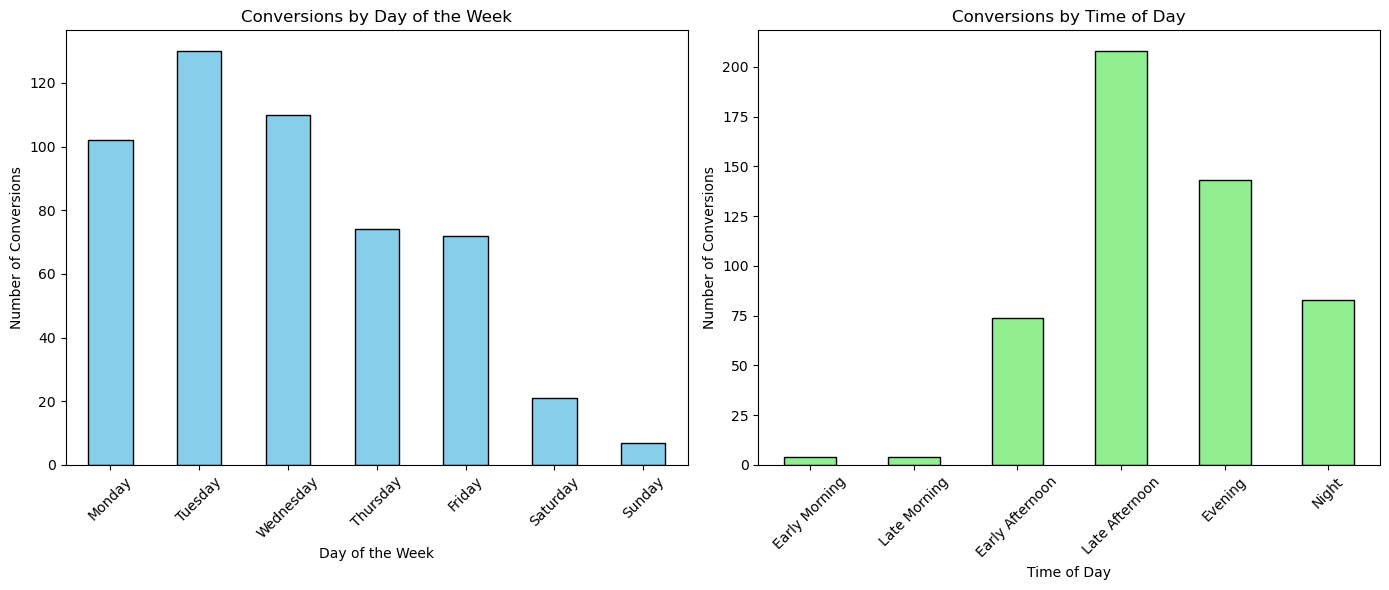

In [153]:
import matplotlib.pyplot as plt


df_time_series['conversion'] = 1

day_of_week_summary = df_time_series.groupby('day_of_week')['conversion'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

time_of_day_summary = df_time_series.groupby('time_of_day')['conversion'].sum().reindex(
    ['Early Morning', 'Late Morning', 'Early Afternoon', 'Late Afternoon', 'Evening', 'Night']
)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
day_of_week_summary.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Conversions by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Conversions')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
time_of_day_summary.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Conversions by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Number of Conversions')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


month
7      57
8     149
9     136
10    174
Name: conversion, dtype: int64


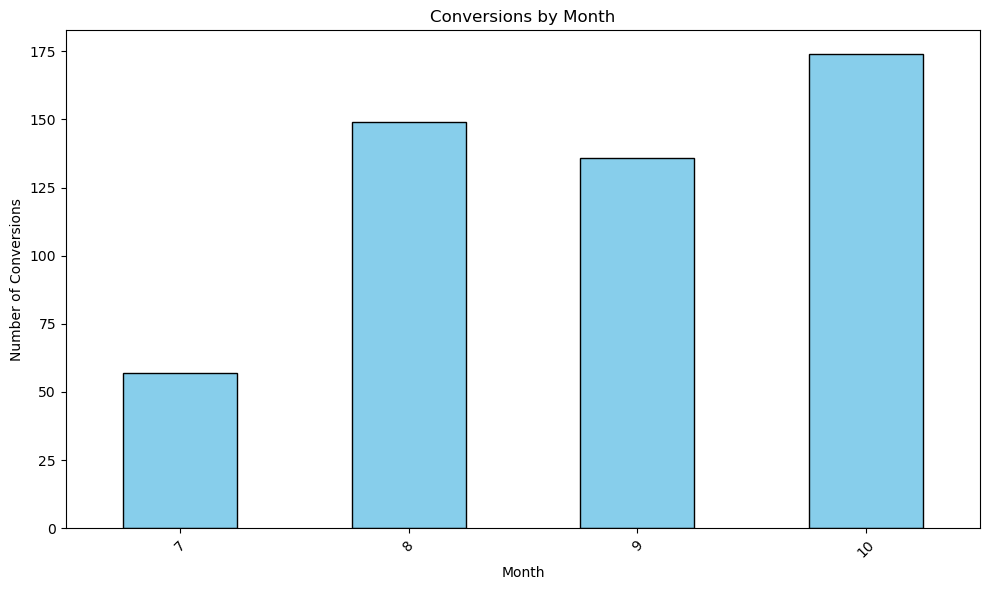

In [155]:
#Grouping totals by month
df_time_series = df[['created_at']].copy() 
df_time_series['created_at'] = pd.to_datetime(df_time_series['created_at'], format='%m/%d/%y %H:%M')

df_time_series['date'] = df_time_series['created_at'].dt.date
df_time_series['time'] = df_time_series['created_at'].dt.time
df_time_series['day_of_week'] = df_time_series['created_at'].dt.day_name()
df_time_series['hour'] = df_time_series['created_at'].dt.hour

def time_of_day(hour):
    if 5 <= hour < 9:
        return 'Early Morning'
    elif 9 <= hour < 12:
        return 'Late Morning'
    elif 12 <= hour < 15:
        return 'Early Afternoon'
    elif 15 <= hour < 18:
        return 'Late Afternoon'
    elif 18 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df_time_series['time_of_day'] = df_time_series['hour'].apply(time_of_day)

df_time_series.drop(columns=['hour'], inplace=True)

df_time_series['conversion'] = 1
df_time_series['month'] = df_time_series['created_at'].dt.month

monthly_summary = df_time_series.groupby('month')['conversion'].sum()

print(monthly_summary)

plt.figure(figsize=(10, 6))
monthly_summary.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Conversions by Month')
plt.xlabel('Month')
plt.ylabel('Number of Conversions')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


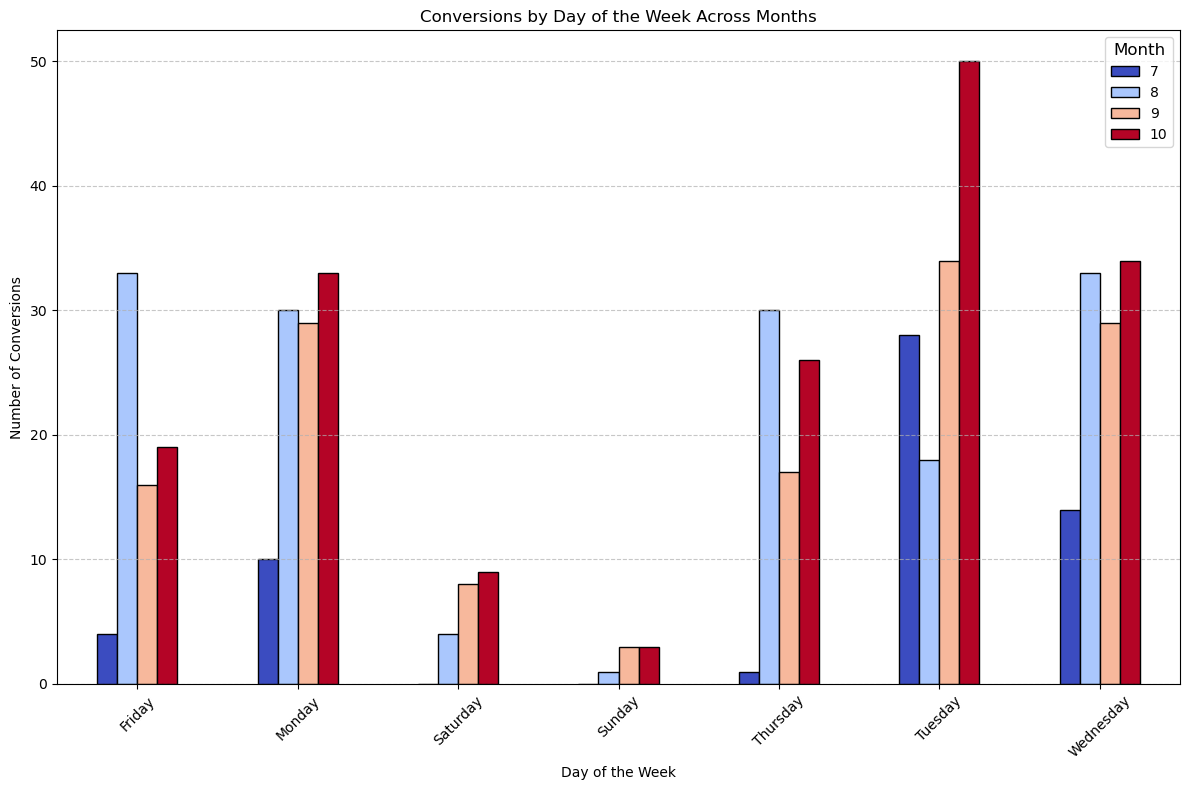

In [157]:
#looking at the trends on a weekly basis


df_time_series['month'] = pd.to_datetime(df_time_series['date']).dt.month

monthly_weekly_conversions = df_time_series.groupby(['month', 'day_of_week']).size().reset_index(name='conversion_count')

pivot_data = monthly_weekly_conversions.pivot(index='day_of_week', columns='month', values='conversion_count')

pivot_data.plot(kind='bar', figsize=(12, 8), cmap='coolwarm', edgecolor='black')

plt.title('Conversions by Day of the Week Across Months')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Conversions')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Month', title_fontsize='12', fontsize='10')

plt.tight_layout()
plt.show()



### Time Series Results

- High Conversion Days Were Tue and Wed: Conversions peaked consistently on Tuesdays and Wednesdays across all months, indicating a strong mid-week activity. Sales efforts focused on these days could yield the highest results.

- Strongest Month was Oct: Conversion counts showed an increase from sept to oct after a drop from aug to sept. This suggests that marketing or other initiatives we had were gaining traction.

- Weekend Dip: Conversions were lowest on weekends, with Saturdays consistently underperforming.

- Peak Conversion Times: Conversions were significantly higher during the late afternoon (3 PM - 6 PM) and evening hours (6 PM - 9 PM). Customers seem to be more responsive towards the end of the day, possibly after their work hours. Targeting outreach during these times could improve engagement and conversions.